In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['mathtext.fontset'] = 'stix' 
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams["figure.dpi"] = 1200 # i'll turn this on for the figures but now for now

In [2]:
# helper function pre-installed (we made our own in the last notebook)
# move these two guys up to the top
def gen_periodic_data(x, period=1, amplitude=1, phase=0, noise=0):
    '''Generate periodic data given the function inputs
    
    y = A*cos(x/p - phase) + noise
    
    Parameters
    ----------
    x : array-like
        input values to evaluate the array
    
    period : float (default=1)
        period of the periodic signal
    
    amplitude : float (default=1)
        amplitude of the periodic signal
    
    phase : float (default=0)
        phase offset of the periodic signal
    
    noise : float (default=0)
        variance of the noise term added to the periodic signal
    
    Returns
    -------
    y : array-like
        Periodic signal evaluated at all points x
    '''
    
    y = amplitude*np.sin(2*np.pi*x/(period) - phase) + np.random.normal(0, np.sqrt(noise), size=len(x))
    return y

In [3]:
# helper function pre-installed (we made our own in the last notebook)
def phase_plot(x, y, period, y_unc = 0.0, mag_plot=False):
    '''Create phase-folded plot of input data x, y
    
    Parameters
    ----------
    x : array-like
        data values along abscissa

    y : array-like
        data values along ordinate

    period : float
        period to fold the data
        
    y_unc : array-like
        uncertainty of the 
    '''    
    phases = (x/period) % 1
    if isinstance(y_unc, (np.floating, float)):
        y_unc = np.ones_like(x)*y_unc

    plot_order = np.argsort(phases)
    fig, ax = plt.subplots()
    ax.errorbar(phases[plot_order], y[plot_order], y_unc[plot_order],
                 fmt='o', mec="0.2", mew=0.1)
    ax.set_xlabel("phase")
    ax.set_ylabel("signal")
    if mag_plot:
        ax.set_ylim(ax.get_ylim()[::-1])
    fig.tight_layout()

# Real World Considerations for the Lomb-Scargle Periodogram

**Version 0.2**

* * *

By AA Miller (Northwestern/CIERA)  
As before, modified by Sameer Singh 

In [4]:
np.random.seed(185)
# calculate the periodogram

x = 10*np.random.rand(100)
y = gen_periodic_data(x, period=5.25, amplitude=7.4, noise=0.8)
y_unc = np.ones_like(x)*np.sqrt(0.8)

## Problem 1) Other Considerations and Faster Implementations

While our "home-grown" `ls_periodogram` works, it would take a loooooong time to evaluate $\sim4\times 10^5$ frequencies for $\sim2\times 10^7$ variable LSST sources. (as is often the case...) `astropy` to the rescue!

**Problem 1a**

[`LombScargle`](https://docs.astropy.org/en/stable/timeseries/lombscargle.html) in `astropy.timeseries` is fast. Run it below to compare to `ls_periodogram`.

In [5]:
from astropy.timeseries import LombScargle
frequency, power = LombScargle(x, y, y_unc).autopower()

Unlike `ls_periodogram`, `LombScargle` effectively takes no time to run on the simulated data. 

**Problem 1b**

Plot the periodogram for the simulated data.

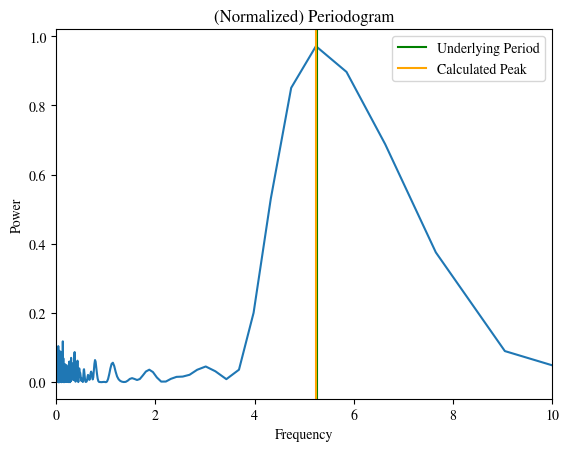

In [6]:
fig, ax = plt.subplots()

ax.plot(1/frequency, power) 
ax.set_xlabel("Frequency")
ax.set_ylabel("Power")
ax.set_title("(Normalized) Periodogram")
ax.axvline(x=5.25, label = "Underlying Period", color = "green")
ax.set_xlim(0, 10)
ax.axvline(1/frequency[np.argmax(power)], label = "Calculated Peak", color = "orange")
ax.legend()

**Problem 1c**

Remove the observations from `x` and `y` where $y \le -2$ and calculate the periodogram both with and without fitting the mean (`fit_mean = False` in the call to `LombScargle`). Plot the periodograms. Do both methods recover the correct period? 

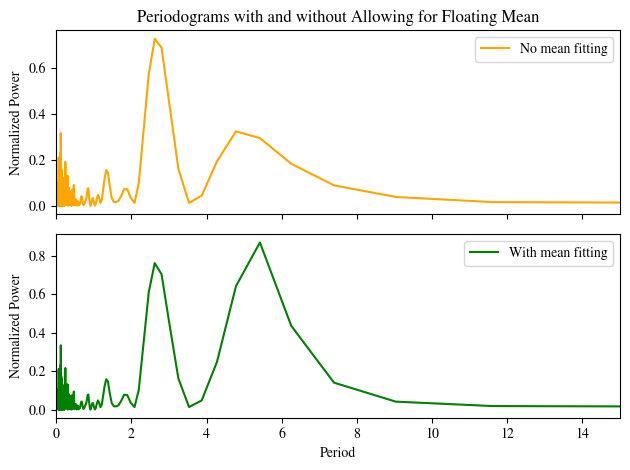

In [7]:
valid_indices = np.where(y >= -2)
valid_x = x[valid_indices] # serves as a "mask," selecting out the correct values
valid_y = y[valid_indices]


freq_no_mean, power_no_mean = LombScargle(valid_x, valid_y, fit_mean = False).autopower() 
freq_fit_mean, power_fit_mean = LombScargle(valid_x, valid_y, fit_mean = True).autopower() # true by default, just be explicit
    
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(1/freq_no_mean, power_no_mean, label = "No mean fitting", color = "orange")
ax2.plot(1/freq_fit_mean, power_fit_mean, label = "With mean fitting", color = "green")
ax1.legend()
ax2.legend()
ax1.set_xlim(0,15)
ax2.set_xlabel("Period")
ax1.set_ylabel("Normalized Power")
ax2.set_ylabel("Normalized Power")
ax1.set_title("Periodograms with and without Allowing for Floating Mean")

fig.tight_layout()

Text(0.5, 1.0, 'Periodogram with Floating Mean Adjustment')

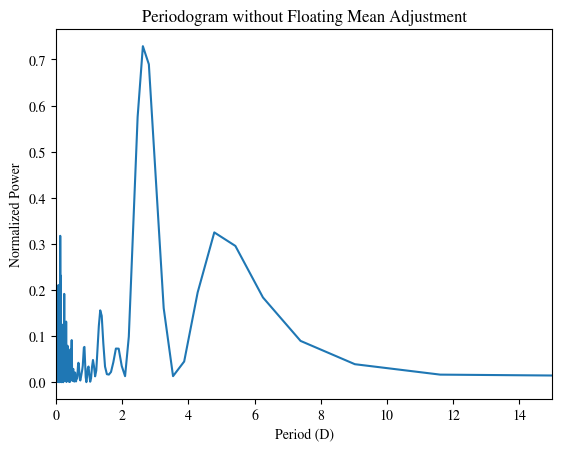

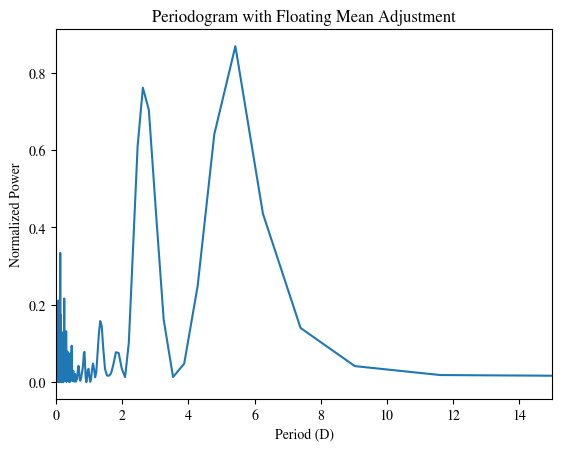

In [8]:
# nicer figures, separate
fig, ax = plt.subplots()
ax.plot(1/freq_no_mean, power_no_mean, label = "No mean fitting")
ax.set_xlim(0, 15)
ax.set_ylabel("Normalized Power")
ax.set_xlabel("Period (D)")
ax.set_title("Periodogram without Floating Mean Adjustment")

fig, ax = plt.subplots()
ax.plot(1/freq_fit_mean, power_fit_mean, label = "No mean fitting")
ax.set_xlim(0, 15)
ax.set_xlabel("Period (D)")
ax.set_ylabel("Normalized Power")
ax.set_title("Periodogram with Floating Mean Adjustment")

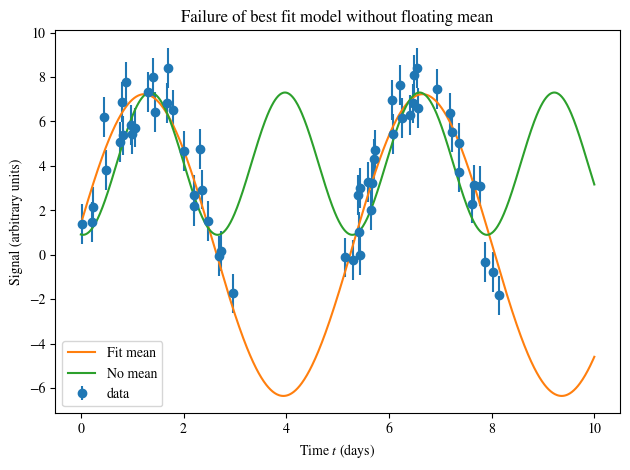

In [9]:
fit_mean_model = LombScargle(x[valid_indices], y[valid_indices], y_unc[valid_indices], 
                             fit_mean=True).model(np.linspace(0,10,1000),
                                                  freq_fit_mean[np.argmax(power_fit_mean)])
no_mean_model = LombScargle(x[valid_indices], y[valid_indices], y_unc[valid_indices], 
                             fit_mean=False).model(np.linspace(0,10,1000),
                                                  freq_no_mean[np.argmax(power_no_mean)])

fig, ax = plt.subplots()
ax.errorbar(x[valid_indices], y[valid_indices], y_unc[valid_indices], fmt='o', label='data')
ax.plot(np.linspace(0,10,1000), fit_mean_model, label='Fit mean')
ax.plot(np.linspace(0,10,1000), no_mean_model, label='No mean')
ax.set_xlabel('Time $t$ (days)')
ax.set_ylabel('Signal (arbitrary units)')
ax.legend()
ax.set_title("Failure of best fit model without floating mean")
fig.tight_layout()

# best fit model fails to match data without floating mean 

Text(0.5, 1.0, 'Simulated LSST Data')

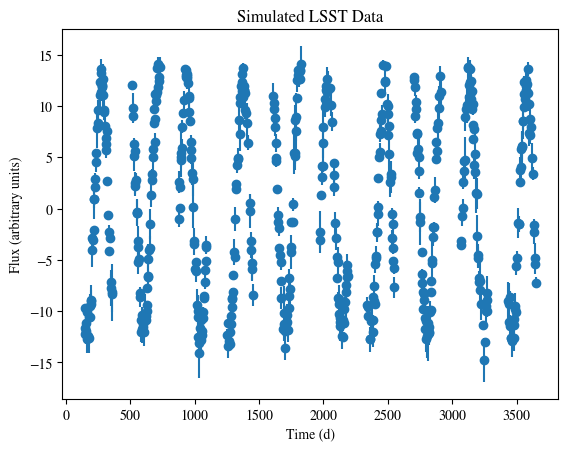

In [10]:
rng = np.random.default_rng()
t_obs = np.arange(0, 10*365, 3) # 3d cadence
t_obs = t_obs + rng.uniform(-1/6, 1/6, len(t_obs))  #  within += 4 hours, since 1/6 of a 24 hours is 4 hours; the random term is the jitter
t_obs = t_obs[(t_obs % 365) / 365 > 0.4]  # drop out the first 40 percent of every year
t_obs = t_obs[rng.random(len(t_obs)) <= 0.7] # idea is that about 70 percent of random numbers between 0 and 1
# will be less than 0.7, so this array is 70% true and 30% false distributed randomly, so it can be used to 
# kill the 30% of the data lost to bad weather


y = gen_periodic_data(t_obs, period=220, amplitude = 12.4, noise = 1)


y_unc = np.abs(rng.standard_normal(size=len(y)))
fig, ax = plt.subplots()

ax.errorbar(t_obs, y, y_unc, fmt = "o")
ax.set_xlabel("Time (d)")
ax.set_ylabel("Flux (arbitrary units)")
ax.set_title("Simulated LSST Data")

**Problem 1e**

Calculate and plot the periodogram for the window function (i.e., set `y = 1` in `LombScargle`) of the observations. Do you notice any significant power? 

*Hint* - you may need to zoom in on the plot to see all the relevant features.

(0.0, 5.0)

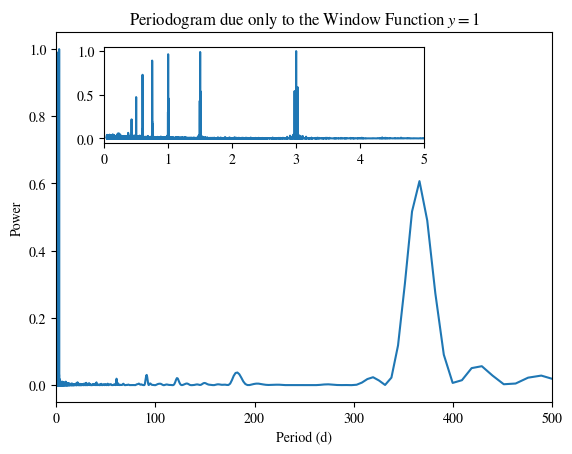

In [11]:
ls = LombScargle(t_obs, y = 1, fit_mean=False, center_data=False) # don't fit a mean and dont center,
# this is not meant to be real analysis of the periodicity in the signal, but of periodicity 
# due to the window
    
freq_window, power_window = ls.autopower(minimum_frequency = 1/(10*365), maximum_frequency = 24)
                                         
# minimum frequency that we are interested in is the minimum scale of astronomical variability, say 1 hr 
# that is a frequency of 24 times per day
# maxmium frequency that we are interested in is the maximum extent of the data, i.e. 10 years 
# that is a frequency of 1/(10*365)
    
    
fig, ax = plt.subplots()
ax.plot(1/freq_window, power_window)
ax.set_ylabel("Power")
ax.set_xlabel("Period (d)")
ax.set_xlim(0,500)
ax.set_title("Periodogram due only to the Window Function $y=1$")

axins = plt.axes([.2, .65, .5, .2])
axins.plot(1/freq_window, power_window)
axins.set_xlim(0,5)

# see peaks at 3 (cadence) and 365 (annual variability)

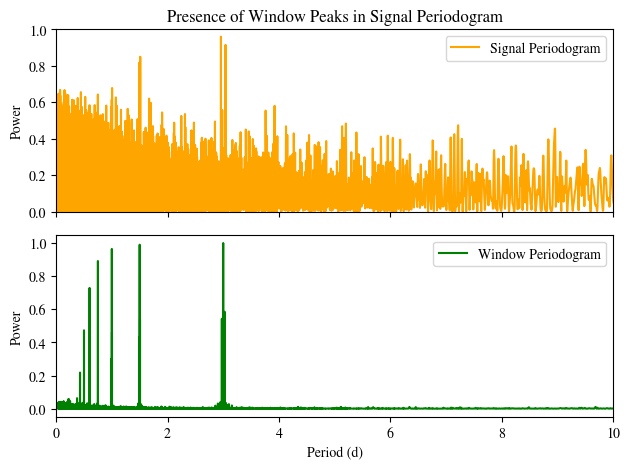

In [12]:
ls = LombScargle(t_obs, y, y_unc, fit_mean = True, center_data = True) 

frequency, power = ls.autopower(minimum_frequency = 1/(10*365), maximum_frequency = 24)

fig, (ax,ax2) = plt.subplots(2,1, sharex=True)
ax.plot(1/frequency,  power, label = "Signal Periodogram", color = 'orange')
ax.set_ylabel("Power")
ax.set_ylim(0,1)
ax.legend()

ax2.plot(1/freq_window, power_window, label = "Window Periodogram", color = 'green')
ax2.set_ylabel("Power")
ax2.set_xlabel("Period (d)")
ax2.set_xlim(0,10)
ax2.legend()

ax.set_title("Presence of Window Peaks in Signal Periodogram")
fig.tight_layout()

# notice that the window power is also present in the signal power 

## Problem 2) Real-world considerations

~~We have covered many, though not all, considerations that are necessary when employing a Lomb Scargle periodogram. We have not yet, however, encountered real world data. Here we highlight some of the issues associated with astronomical light curves.~~

~~We will now use LS to analyze actual data from the [All Sky Automated Survey (ASAS)](http://www.astrouw.edu.pl/asas/?page=catalogues). Download the [example light curve](https://northwestern.box.com/s/rclcz4lkcdfjn4829p8pa5ddfmcyd0gm).~~

This data from the original work by Miller is not available!! As for my own real-astronomical analysis, I'll do it on an eclipsing binary in a separate notebook instead (see my paper).

## Problem 3) The "Real" World

**Problem 3a** 

Re-write `gen_periodic_data` to create periodic signals using the first 4 harmonics in a Fourier series. The $n > 1$ harmonics should have random phase offsets, and the amplitude of the $n > 1$ harmonics should be drawn randomly from a uniform distribution between 0 and `amplitude` the amplitude of the first harmonic.

In [13]:
def gen_periodic_data(x, period=1, amplitude=1, phase=0, noise=0):
    '''Generate periodic data
    
    Parameters
    ----------
    x : array-like
        input values to evaluate the array
    
    period : float (default=1)
        period of the periodic signal
    
    amplitude : float (default=1)
        amplitude of the periodic signal
    
    phase : float (default=0)
        phase offset of the periodic signal
    
    noise : float (default=0)
        variance of the noise term added to the periodic signal
    
    Returns
    -------
    y : array-like
        Periodic signal evaluated at all points x
    '''
    
    y1 = amplitude*np.sin(2*np.pi*x/(period) - phase)
    amp2 = rng.uniform(0, amplitude)
    phase2 = rng.uniform(0, 2*np.pi)
    y2 = amp2*np.sin(2*2*np.pi*x/(period) - phase2) # second harmonic so twice the fundamental frequency, and so on
    amp3 = rng.uniform(0, amplitude)
    phase3 = rng.uniform(0, 2*np.pi)
    y3 = amp3*np.sin(3*2*np.pi*x/(period) - phase3)
    amp4 = rng.uniform(0, amplitude)
    phase4 = rng.uniform(0, 2*np.pi)
    y4 = amp4*np.sin(4*2*np.pi*x/(period) - phase4)
    dy =  np.random.normal(0, np.sqrt(noise), size=len(x)) # noise, just copy built from premade below
    return y1 + y2 + y3 + y4 + dy

**Problem 3b**

Confirm the updated version of `gen_periodic_data` works by creating a phase plot for a simulated signal with `amplitude = 4`, `period = 1.234`, and `noise=0.81`, and 100 observations obtained on a regular grid from 0 to 50.

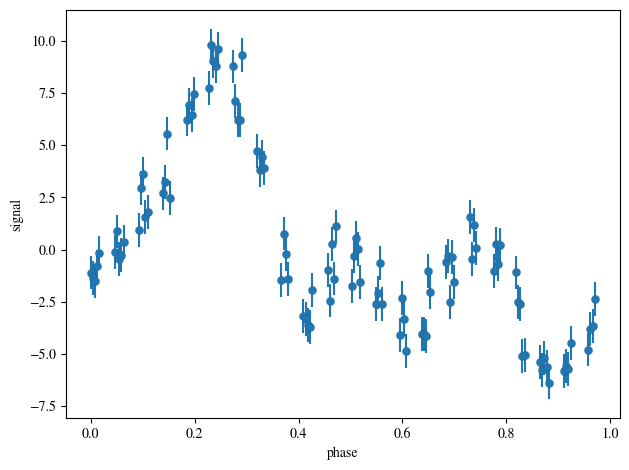

In [14]:
np.random.seed(185)
x_grid = np.linspace(0, 50, 100) 
y = gen_periodic_data(x = x_grid, amplitude = 4, period = 1.234, noise = 0.81) 

phase_plot(x_grid, y, period=1.234, y_unc = 0.81) 

**Problem 3c** 

Simulate 1000 "realistic" light curves using the astronomical cadence from **1d** for a full survey duration of 2 years. 

For each light curve draw the period randomly from [0.2, 10], and the amplitude randomly from [1, 5], and the noise randomly from [1,2].

Record the period in an array `true_p` and estimate the period for the simulated data via LS and store the result in an array `ls_p`.

In [15]:
n_lc = 1000 
true_p = np.zeros(n_lc)
ls_p = np.zeros_like(true_p)

for lc in range(n_lc):
    # set up simulated observations
    t_obs = np.arange(0, 2*365, 3)
    t_obs = t_obs + rng.uniform(-1/6, 1/6, len(t_obs))
    t_obs = t_obs[(t_obs % 365) / 365 > 0.4]  
    t_obs = t_obs[rng.random(len(t_obs)) <= 0.7]
    
    period = rng.uniform(0.2, 10)
    true_p[lc] = period
    amp = rng.uniform(1,5)
    noise = rng.uniform(1,2)
    y = gen_periodic_data(t_obs, period=period, amplitude=amp, noise=noise)
    freq, power = LombScargle(t_obs, y, np.ones_like(y)*noise).autopower(minimum_frequency=1/730, maximum_frequency=12)
    ls_p[lc] = 1/freq[np.argmax(power)]


**Problem 3d**

Plot the LS recovered period vs. the true period for the simulated sources. 

Do you notice anything interesting? Do you manage to recover the correct period most of the time?

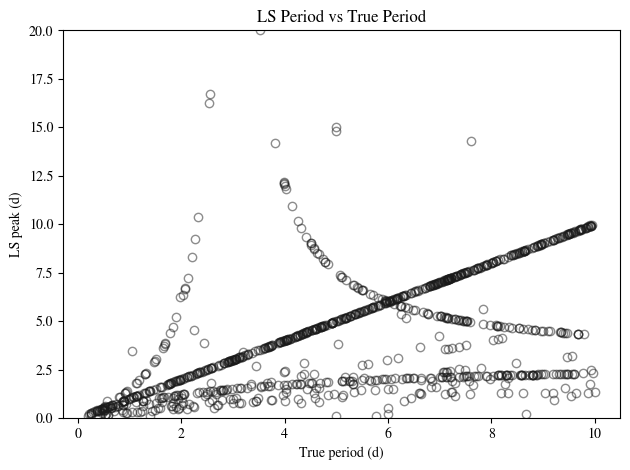

In [16]:
fig, ax = plt.subplots()
ax.plot(true_p, ls_p, 'o', mfc='None', mec='0.1', alpha=0.5)
ax.set_ylim(0, 20)
ax.set_xlabel('True period (d)')
ax.set_ylabel('LS peak (d)')
ax.set_title('LS Period vs True Period')
fig.tight_layout()

**Problem 3e**

For how many of the simulated sources do you recover the correct period? Consider a period estimate "correct" if the LS estimate is within 10% of the true period.

In [17]:
# true periods are true_p
# ls periods are ls_p
diff = np.abs(true_p - ls_p)
relative_diff = (diff / true_p)
correct_count = len(np.where(relative_diff <= 0.1)[0]) # need the zero because np.where returns a tuple
percent_correct = (correct_count/ len(true_p)) * 100

print(f"We were able to recover the correct period for {round(percent_correct, 3)}% of simulated sources.")

We were able to recover the correct period for 51.2% of simulated sources.


**Problem 3f**

Recreate the plot in **3d** and overplot the line

$$P_\mathrm{LS} = \left(\frac{1}{P_\mathrm{true}} + \frac{n}{3}\right)^{-1}$$

for $n = -2, -1, 1, 2$.

*Hint* - only plot the values where $P_\mathrm{LS} > 0$ since, by definition, we do not search for negative periods.

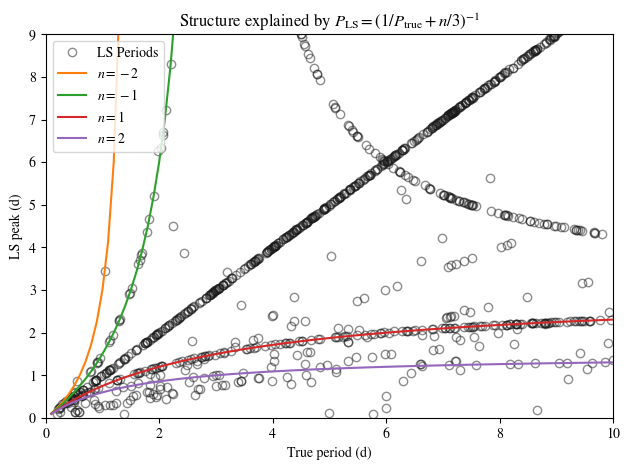

In [18]:
p_grid = np.linspace(1e-1, 10, 100)

fig, ax = plt.subplots()
ax.plot(true_p, ls_p, 'o', mfc='None', mec='0.1', alpha=0.5, label='LS Periods')

for n in [-2, -1, 1, 2]:
    P_LS_denom = (1 / p_grid + n / 3) # the reason we're doing it like this instead of just
    # calculating the full expression is to avoid divison by zero errors down the line
    valid_indices = np.where(P_LS_denom > 0)
    p_grid_valid = p_grid.copy()[valid_indices]
    P_LS_denom_valid = P_LS_denom[valid_indices]
    ax.plot(p_grid_valid , 1/P_LS_denom_valid, label=f'$n ={n}$')

ax.set_ylim(0, 9)
ax.set_xlim(0, 10)
ax.set_xlabel('True period (d)')
ax.set_ylabel('LS peak (d)')
ax.legend()
ax.set_title(r"Structure explained by $P_\mathrm{LS} = (1/P_\mathrm{true} + n/3)^{-1}$")
fig.tight_layout()

# this plot describes aliasing of the true frequency by the window function and its harmonics

**Problem 3g**

Recreate the plot in **3d** and overplot lines for the $m = 2$ harmonic aliased with $n = -1, 1, 2$.

*Hint* - only plot the values where $P_\mathrm{LS} > 0$ since, by definition, we do not search for negative periods.

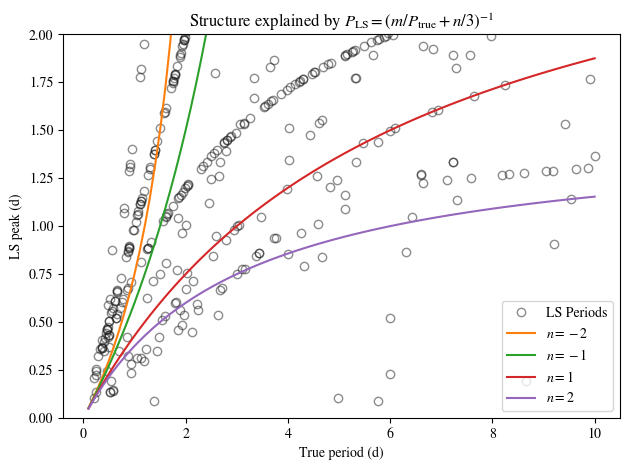

In [19]:
p_grid = np.linspace(1e-1, 10, 100)

fig, ax = plt.subplots()
ax.plot(true_p, ls_p, 'o', mfc='None', mec='0.1', alpha=0.5, label='LS Periods')

for n in [-2, -1, 1, 2]:
    P_LS_denom = (2/ p_grid + n / 3) # the reason we're doing it like this instead of just
    # calculating the full expression is to avoid divison by zero errors down the line
    valid_indices = np.where(P_LS_denom > 0)
    p_grid_valid = p_grid.copy()[valid_indices]
    P_LS_denom_valid = P_LS_denom[valid_indices]
    ax.plot(p_grid_valid , 1/P_LS_denom_valid, label=f'$n ={n}$')
    ax.legend()

# this plot describes aliasing of the second harmonic by the window function and its harmonics

ax.set_ylim(0, 2)
ax.set_xlabel('True period (d)')
ax.set_ylabel('LS peak (d)')
ax.set_title("Structure explained by $P_\mathrm{LS} = (m/P_\mathrm{true} + n/3)^{-1}$")
fig.tight_layout()

**Problem 3h**

Recreate the plot in **3d** and overplot lines for the "reflected" $m = 1$ harmonic aliased with $n = -3, -2, -1$.

*Hint* - only plot the values where $P_\mathrm{LS} < 0$ since we are looking for "reflected" peaks in the periodogram in this case. 

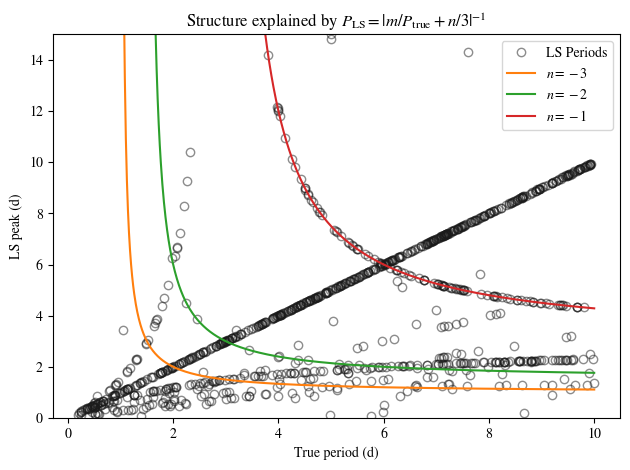

In [20]:
p_grid = np.linspace(1e-1,10,1000)

fig, ax = plt.subplots()
ax.plot(true_p, ls_p, 'o', mfc='None', mec='0.1', alpha=0.5, label = "LS Periods")
for n in [-3, -2, -1]:
    P_LS_denom = (1 / p_grid + n / 3) # the reason we're doing it like this instead of just
    # calculating the full expression is to avoid divison by zero errors down the line
    valid_indices = np.where(P_LS_denom < 0)
    p_grid_valid = p_grid.copy()[valid_indices]
    P_LS_denom_valid = P_LS_denom[valid_indices]
    ax.plot(p_grid_valid, np.abs(1/P_LS_denom_valid), label=f'$n ={n}$') # here we need abs
    ax.legend()
    # because these are negative and would not show up otherwise

ax.set_ylim(0, 15)
ax.set_xlabel('True period (d)')
ax.set_ylabel('LS peak (d)')
ax.set_title("Structure explained by $P_\mathrm{LS} = |m/P_\mathrm{true} + n/3|^{-1}$")
fig.tight_layout()

# this plot refers issues coming from the symmetry of the LS periodogram about 0

Now we have seen that nearly all the structure in the LS period vs. true period plot can be explained via aliasing with the window function.